# Damage Propagation Modeling 
# Aircraft Engine Run-to-Failure Simulation

- Damage propagation was allowed to continue until a failure criterion was reached. A health index was defined as the minimum of several superimposed operational margins at any given time instant and the failure criterion is reached when health index reaches zero. Output of the model was the time series (cycles) of sensed measurements typically available from aircraft gas turbine engines. 

- Prognostics here exclusively as the estimation of remaining useful component life. The remaining useful life (RUL) estimates are in units of time (e.g., hours or cycles). End-of-life can be subjectively determined as a function of operational thresholds that can be measured. These thresholds depend on user specifications to determine safe operational limits.

- An important requirement for the damage modeling process was the availability of a suitable system model that allows input variations of health related parameters and recording of the resulting output sensor measurements. The recently released C-MAPSS (Commercial Modular Aero- Propulsion System Simulation)

- C-MAPSS is a tool for simulating a realistic large commercial turbofan engine. The software is coded in the MATLAB® and Simulink® environment, and includes a number of editable input parameters that allow the user to enter specific values of his/her own choice regarding operational profile, closed-loop controllers, environmental conditions, etc

Data Set: FD001 ==>
Train trjectories: 100,
Test trajectories: 100,
Conditions: ONE (Sea Level),
Fault Modes: ONE (HPC Degradation)

Data Set: FD002 ==>
Train trjectories: 260,
Test trajectories: 259,
Conditions: SIX,
Fault Modes: ONE (HPC Degradation)

###Experimental Scenario###

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine ñ i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn.metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import tensorflow as tf
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Each row is a snapshot of data taken during a single operational cycle, each column is a different variable.

In [2]:
rul_1_gt = pd.read_csv('../input/cmapssdata/RUL_FD001.txt', header=None)

rul_1_gt.rename(columns={0: "RUL_1gt"}, inplace=True)
################   ################   ################   ################   

column_name_dict={ 0: "engine_id", 1: "cycle", 2: "op_set_1", 3: "op_set_2", 4: "op_set_3", 5:"sensor_1", 6: "sensor_2",
                   7: "sensor_3", 8: "sensor_4", 9: "sensor_5", 10: "sensor_6", 11: "sensor_7", 12: "sensor_8", 13: "sensor_9",
                  14: "sensor_10", 15: "sensor_11", 16: "sensor_12", 17: "sensor_13", 18: "sensor_14", 19: "sensor_15", 20: "sensor_16",
                  21: "sensor_17", 22: "sensor_18", 23: "sensor_19", 24: "sensor_20", 25: "sensor_21", 26: "sensor_22", 27: "sensor_23"}

test_1 = pd.read_csv('../input/cmapssdata/test_FD001.txt', header=None, sep=' ')

test_1.rename(columns=column_name_dict, inplace=True)

################   ################   ################   ################ 

train_1 = pd.read_csv('../input/cmapssdata/train_FD001.txt', header=None, sep=' ')

train_1.rename(columns=column_name_dict, inplace=True)


In [3]:
train_1

,engine_id,cycle,op_set_1,op_set_2,op_set_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [4]:
#drop the last 2 columns from train and test sets since NaN
train_1.drop(columns=["sensor_22", "sensor_23"], inplace=True)
test_1.drop(columns=["sensor_22", "sensor_23"], inplace=True)

Compute RUL values

In [5]:
#RUL for train_1 
rul_1 = pd.DataFrame(train_1.groupby('engine_id')['cycle'].max()).reset_index()
rul_1.columns = ['engine_id', 'max']

rul_train_1 = train_1.merge(rul_1, on=['engine_id'], how='left')
rul_train_1['RUL'] = rul_train_1['max'] - rul_train_1['cycle']
rul_train_1.drop(['max'], axis=1, inplace=True)

In [6]:
#RUL for test_1
rul_1_gt["engine_id"]=rul_1_gt.index + 1

max_1 = pd.DataFrame(test_1.groupby('engine_id')['cycle'].max()).reset_index()
max_1.columns = ['engine_id', 'max']
max_test_1 = test_1.merge(max_1, on=['engine_id'], how='left')
rul_test_1 = max_test_1.merge(rul_1_gt, on=['engine_id'], how='left')

rul_test_1['RUL'] = rul_test_1['max'] - rul_test_1['cycle'] + rul_test_1["RUL_1gt"] 
rul_test_1.drop(['max', 'RUL_1gt'], axis=1, inplace=True)


In [7]:
rul_train_1.groupby('engine_id')['cycle'].describe()

,count,mean,std,min,25%,50%,75%,max
engine_id,,,,,,,,
1,192.0,96.5,55.569776,1.0,48.75,96.5,144.25,192.0
2,287.0,144.0,82.993976,1.0,72.50,144.0,215.50,287.0
3,179.0,90.0,51.816986,1.0,45.50,90.0,134.50,179.0
4,189.0,95.0,54.703748,1.0,48.00,95.0,142.00,189.0
5,269.0,135.0,77.797815,1.0,68.00,135.0,202.00,269.0
...,...,...,...,...,...,...,...,...
96,336.0,168.5,97.139076,1.0,84.75,168.5,252.25,336.0
97,202.0,101.5,58.456537,1.0,51.25,101.5,151.75,202.0
98,156.0,78.5,45.177428,1.0,39.75,78.5,117.25,156.0


In [8]:
rul_train_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_set_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_set_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_set_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [9]:
#drop columns which has std=0 because they don't carry info about the state of the unit
deleted_1=["op_set_3", "sensor_18", "sensor_19"]

rul_train_1.drop(columns=deleted_1, inplace=True)
rul_test_1.drop(columns=deleted_1, inplace=True)

Corr Matrix

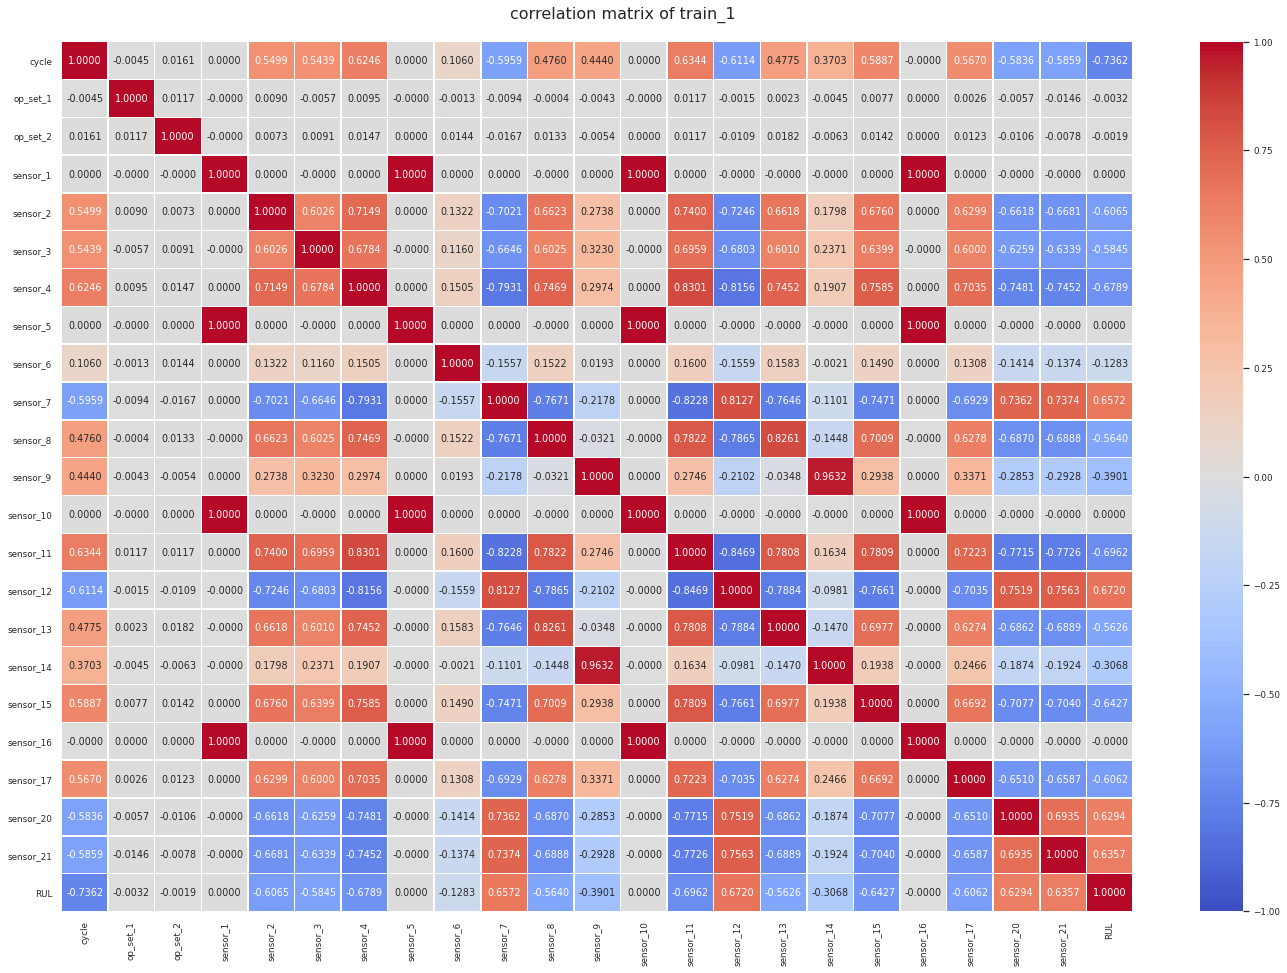

In [10]:
#heatmap for correlation coefficient

# calculate correlation
df_corr = rul_train_1.drop(columns=["engine_id"]).corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(24,16))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("coolwarm", 200))

plt.figtext(.45, 0.9,'correlation matrix of train_1', fontsize=16, ha='center')
plt.xticks(rotation=90)
plt.show()


In [11]:
#corr(RUL&feature )==0 ==> will be deleted since it has no corr between target(RUL) 
corr_del=["sensor_1", "sensor_5", "sensor_10", "sensor_16"]
rul_train_1.drop(columns=corr_del, inplace=True)

# FEATURE SELECTION

1. Random Forest importances:

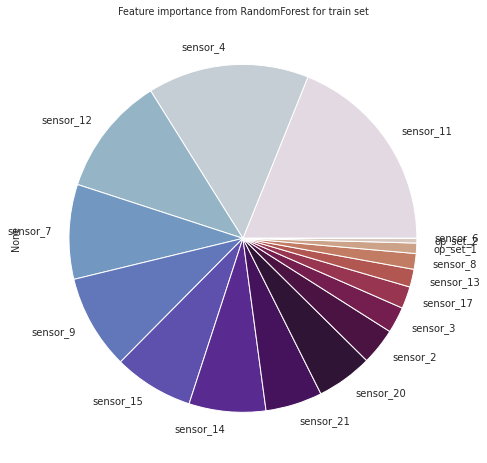

In [12]:
#X, y splitting
X_imp=rul_train_1.drop(columns=["RUL", "engine_id", "cycle"])
y_imp=rul_train_1["RUL"]

#feature importances
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth=5)
rf_clf.fit(X_imp, y_imp)

pd.Series(rf_clf.feature_importances_, index = X_imp.columns).nlargest(30).plot(kind = 'pie',
                                                                                figsize = (8, 8),
                                                                                title = 'Feature importance from RandomForest for train set', colormap='twilight', fontsize=10)

2. w Permutation importance:

- [permutation importances](http://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

- This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

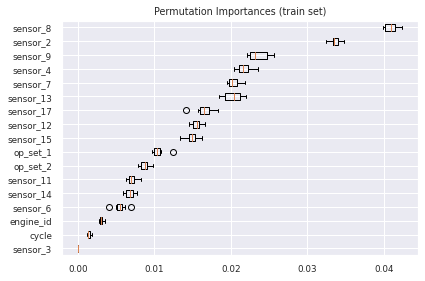

sensor_8 0.041 +/- 0.001
sensor_2 0.034 +/- 0.001
sensor_9 0.024 +/- 0.001
sensor_4 0.022 +/- 0.001
sensor_7 0.020 +/- 0.001
sensor_13 0.020 +/- 0.001
sensor_17 0.016 +/- 0.001
sensor_12 0.016 +/- 0.001
sensor_15 0.015 +/- 0.001
op_set_1 0.010 +/- 0.001
op_set_2 0.009 +/- 0.001
sensor_11 0.007 +/- 0.001
sensor_14 0.007 +/- 0.001
sensor_6 0.006 +/- 0.001
engine_id 0.003 +/- 0.000
cycle    0.001 +/- 0.000
sensor_3 0.000 +/- 0.000


In [13]:
# permutation importance with RF classifier for deciding to elimination bet. 9&14 since they are highly correlated
atts=rul_train_1.columns
atts_arr = np.array(atts)
result = permutation_importance(rf_clf, X_imp, y_imp, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=atts_arr[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

for i in result.importances_mean.argsort()[::-1]:
     print(f"{atts_arr[i]:<8} "
           f"{result.importances_mean[i]:.3f}"
           f" +/- {result.importances_std[i]:.3f}")


In [14]:
#corr matrix results to be deleted 14-9
train_1_del=["sensor_14"]
train_1.drop(columns=train_1_del, inplace=True)

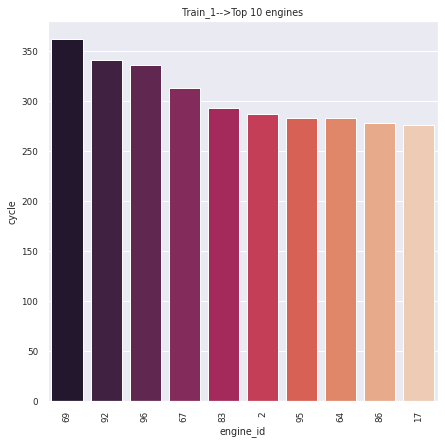

In [15]:
dd_1=train_1.groupby('engine_id')['cycle'].max().reset_index().sort_values("cycle", ascending=False)

dd_1.reset_index(drop=True, inplace=True)
train_1_top=dd_1.head(10)

plt.figure(figsize=(7,7))
sns.barplot(x="engine_id", y="cycle", data=train_1_top, palette="rocket", order=train_1_top['engine_id'])
plt.title("Train_1-->Top 10 engines")
plt.xticks(rotation=90);

#  NORMALIZATION: MinMax Scaling

In [16]:
#train_1 minmax scaling
cols_normalize_1 = rul_train_1.columns.difference(['engine_id','cycle'])

scaler_1 = MinMaxScaler()
norm_rul_train_1 = pd.DataFrame(scaler_1.fit_transform(rul_train_1[cols_normalize_1]), 
                                columns=cols_normalize_1, 
                                index=rul_train_1.index)

norm_rul_train_1=pd.concat([norm_rul_train_1, rul_train_1[["engine_id", "cycle"]]], axis=1)

################   ################   ################   ################   ################

#test_1 minmax scaling
norm_rul_test_1 = pd.DataFrame(scaler_1.transform(rul_test_1[cols_normalize_1]), 
                                columns=cols_normalize_1, 
                                index=rul_test_1.index)

norm_rul_test_1=pd.concat([norm_rul_test_1, rul_test_1[["engine_id", "cycle"]]], axis=1)



In [17]:
#split engines for set_1
g_1=norm_rul_train_1.groupby('engine_id')
g_test1=norm_rul_test_1.groupby('engine_id')

#list of dfs(engines)
train_list = []
test_list = []  

for engineid in g_1.groups.keys():
    train_list.append(g_1.get_group(engineid)) 

for engineid in g_test1.groups.keys():
    test_list.append(g_test1.get_group(engineid))

In [18]:
len(train_list)

100

In [19]:
len(test_list)

100

In [20]:
#generating sequences for each engine --> multivariate one step problem
from numpy import array

#df: df extracted from train_list, n_steps: window size
def split_sequences(df, n_steps):
    X, y = list(), list()
    for i in range(len(df)):
        end_ix = i + n_steps
        if end_ix > len(df):
            break
        seq_x, seq_y = df[i:end_ix, 1:], df[end_ix-1, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


list_x=[]
list_y=[]
for engine_df in train_list:
    #convert df to arr 
    engine_arr=engine_df.drop(columns=["engine_id", "cycle"]).to_numpy()
    X, y = split_sequences(engine_arr, 21)#since smallest df has 21 rows
    list_x.append(X)
    list_y.append(y)

#concat alt alta  
X_arr=np.concatenate(list_x)
y_arr=np.concatenate(list_y)

In [21]:
engine_arr.shape #input of split_seq function

(200, 18)

In [22]:
X.shape #output of split_seq function

(180, 21, 17)

In [23]:
y.shape #output of split_seq function

(180,)

In [24]:
X_arr.shape #concat all engines

(18631, 21, 17)

In [25]:
y_arr.shape

(18631,)

# Define LSTM Model

In [26]:
seq_len=X_arr.shape[1]
num_features=X_arr.shape[2]

model = Sequential()
model.add(LSTM(input_shape=(seq_len, num_features), units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

#This callback will stop the training when there is no improvement in the validation loss for 20 consecutive epochs. 
#regularization technique as preventing overfitting, model runtime gets shorter
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# fit model
history=model.fit(X_arr, y_arr, epochs=200, callbacks=[callback])
len(history.history['loss']) 


Epoch 1/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0160
Epoch 2/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0123
Epoch 3/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0110
Epoch 4/200
583/583 [==============================] - 4s 8ms/step - loss: 0.0106
Epoch 5/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0103
Epoch 6/200
583/583 [==============================] - 5s 9ms/step - loss: 0.0102
Epoch 7/200
583/583 [==============================] - 5s 8ms/step - loss: 0.0101
Epoch 8/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0098
Epoch 9/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0097
Epoch 10/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0095
Epoch 11/200
583/583 [==============================] - 4s 7ms/step - loss: 0.0094
Epoch 12/200
583/583 [==============================] - 5s 8ms/step - loss: 0.0093
Epoch 13/200


200

# PREDICTION

In [27]:
#prepare test set to make predictions
list_x_test=[]
list_y_test=[]

for engine_df in test_list:
    #convert df to arr 
    engine_arr=engine_df.drop(columns=["engine_id", "cycle"]).to_numpy()
    X, y = split_sequences(engine_arr, seq_len)
    
    #use only last seq for each engine
    list_x_test.append(X[-1].reshape((1, seq_len, num_features)))
    list_y_test.append(y[-1].reshape((1, )))

#concat alt alta  
X_arr_test=np.concatenate(list_x_test)
y_arr_test=np.concatenate(list_y_test)

In [28]:
X_arr_test.shape

(100, 21, 17)

In [29]:
y_arr_test.shape

(100,)

We have to make inverse scaling for RUL column in order to produce proper prediction results

In [30]:
#create a dummy df to take inverse only on one col --> "y_pred"
def invTransform(scaler, y_pred, colNames):
    dummy = pd.DataFrame(np.zeros((len(y_pred), len(colNames))), columns=colNames)
    dummy["RUL"] = y_pred
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy["RUL"].values

In [31]:
#prediction
y_pred = model.predict(X_arr_test, verbose=0)

#inverse scaling for y_pred values
y_pred_inv=invTransform(scaler_1, y_pred, cols_normalize_1)

y_pred_reshaped=y_pred_inv.reshape((len(y_pred_inv, )))
y_pred_reshaped.shape

(100,)

In [32]:
y_truth=rul_1_gt["RUL_1gt"].values
y_truth.shape

(100,)

# SCORES

In [33]:
y_truth

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

In [34]:
y_pred_reshaped

array([163.49804845, 150.6297164 ,  43.74402118,  66.79577026,
       154.74367985, 168.5031822 , 146.46199203, 156.3521716 ,
       144.24781045,  83.85893308,  80.93237902, 109.59312809,
       125.75106445, 145.60742262, 159.82878256, 131.50587088,
        42.29623121,  33.27971224, 132.77339986,  14.56121457,
        67.81602269, 144.41929239, 136.8713975 ,  23.15862001,
       123.61828274, 136.27118382, 134.52928495, 129.62922007,
        94.09970978,  99.89925063,  12.86784792,  55.67670673,
       123.95558757,   7.91279563,  12.52594915,  23.90578593,
        39.95096639,  47.84679027, 127.26004955,  32.14457369,
        57.80727217,  13.09245063, 110.02765873, 209.79415852,
        54.39388973,  38.81556962, 116.32961723, 169.92907834,
        16.48404145, 126.73669559, 127.98196495,  31.14876488,
        29.87130567, 132.18279365, 130.86696914,  14.98835941,
       126.62889403,  47.41069424, 116.93060553, 124.79491198,
        26.43226388,  49.87899485,  98.79869571,  21.34

In [35]:
#error cal. for paper
def score(y_true, y_pred, a1=10, a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [36]:
score(y_truth,y_pred_reshaped)

5727.118141201296

In [37]:
def score_func(y_true, y_pred):
    score_list = [
                  round(score(y_true,y_pred), 2), 
                  round(mean_absolute_error(y_true,y_pred), 2),
                  round(mean_squared_error(y_true,y_pred),2) ** 0.5,
                  round(r2_score(y_true,y_pred), 2)
                  ]
    
    print(f' R2 score: {score_list[3]}')
    print(f' compatitive score: {score_list[0]}')
    print(f' mean absolute error: {score_list[1]}')
    print(f' root mean squared error: {score_list[2]}')
    
    return 0

In [38]:
score_func(y_truth,y_pred_reshaped)

 R2 score: 0.36
 compatitive score: 5727.12
 mean absolute error: 24.05
 root mean squared error: 33.24003610106343


0